In [1]:
%load_ext autoreload
%autoreload 2
import pickle
from datetime import datetime
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp
import sandbox_correct as sb
import importlib
importlib.reload(sb)


<module 'sandbox_correct' from '/home/saha/Desktop/tesis/colera/polaron_revisited/sandbox_correct.py'>

In [6]:
N = 17
cavity_diss_rate = 2*np.pi*0.5*10**6
eff_coupling = 2*np.pi*5*10**6
input_power = 0
rabi_freq = 2*np.pi*20*10**6
qubit_targetz = 20*2*np.pi*10**6
final_time__mus = 0.5
time_steps = 1000
tlist = np.linspace(0, final_time__mus, time_steps)
norm = eff_coupling
parameters = {
    "N": N,
    "final_time__mus": final_time__mus,
    "time_steps": time_steps,
    "input_power": input_power,
    "rabi_freq": rabi_freq,
    "eff_coupling": eff_coupling,
    "qubit_targetz": qubit_targetz,
    "cavity_diss_rate": cavity_diss_rate,
    "norm": norm
}

### This is just to calculate the old cavity drive amplitude
cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz - eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam()) 

H_qubit_target = sb.target_hamiltonian_polaron(parameters)
eigenenergies, eigenstate = H_qubit_target.eigenstates()
psi0_atom = eigenstate[-1]
target_state = eigenstate[0]

parameters["initial_state_qubit"] = psi0_atom


4.064489447282144 4.0


In [8]:
print(parameters)
dynamics = sb.calculate_full_dynamics_polaron(parameters)

x_exp = expect(sx, dynamics)
z_exp = expect(sz, dynamics)
photon_number = expect(d.dag()*d, dynamics)

{'N': 17, 'final_time__mus': 0.5, 'time_steps': 1000, 'input_power': 0, 'rabi_freq': 125663706.14359173, 'eff_coupling': 31415926.535897933, 'qubit_targetz': 125663706.14359173, 'cavity_diss_rate': 3141592.653589793, 'norm': 31415926.535897933, 'initial_state_qubit': Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.92540222]
 [-0.37898646]]}


In [13]:
#compare with target hamiltonian expecation values:

H_qubit = sb.target_hamiltonian_polaron(parameters)
evalues_target, estates_target = H_qubit.eigenstates()
# For ground state
gs_sigmax = expect(sigmax(), estates_target[0])
gs_sigmaz = expect(sigmaz(), estates_target[0])

# For excited state
es_sigmax = expect(sigmax(), estates_target[1])
es_sigmaz = expect(sigmaz(), estates_target[1])

cavity_e_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning + eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])
cavity_g_t = np.array([sb.coherent_field_dynamics(i, cavity_field, cavity_drive_amplitude, 
                                               cavity_detuning - eff_coupling, cavity_diss_rate, N) for i in tlist*1e-6])

coherent_e_t = [coherent(N, i) for i in cavity_e_t]
coherent_g_t = [coherent(N, i) for i in cavity_g_t]

rho_qubit = np.array([ptrace(i, 1) for i in dynamics])
P_g = np.array([i[0,0] for i in rho_qubit]) 
P_e = np.array([i[1,1] for i in rho_qubit])
C_eg =  np.array([i[0,1] for i in rho_qubit])
C_ge =  np.array([i[1,0] for i in rho_qubit])

(rho_qubit[-1]).tr()
#cavity_field_superposition = np.array([P_g[i] * rho_cavity_g_t[i] + P_e[i] * rho_cavity_e_t[i] for i in range(len(tlist))])


1.0000000000000004

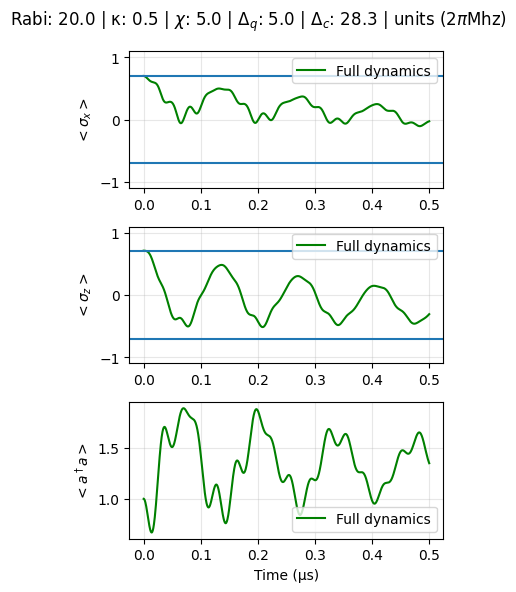

In [10]:
# Generate plot
max_time = 0.5
if max_time is None:
    max_time = max(tlist)

time_mask = tlist <= max_time
tlist_plot = tlist[time_mask]

# Create plot
fig, axes = plt.subplots(3, 1, figsize=(4, 6))

# Plot only up to max_time
axes[0].plot(tlist_plot, x_exp[time_mask], color='#008000', label='Full dynamics')
axes[1].plot(tlist_plot, z_exp[time_mask], color='#008000', label='Full dynamics')
axes[2].plot(tlist_plot, photon_number[time_mask], color='#008000', label='Full dynamics')

#compare with target hamiltonian expecation values:
axes[0].axhline(gs_sigmax)
axes[0].axhline(es_sigmax)
axes[1].axhline(gs_sigmaz)
axes[1].axhline(es_sigmaz)


# axes[2].plot(tlist_plot, photon_number_superposition[time_mask], color='#900080', label='Superposition state')
# axes[2].plot(tlist_plot, photon_number_superposition[time_mask]+photon_number_polaron[time_mask], color="#D60D4D", label='Superposition state')

# # Plot only up to max_time
# axes[0].plot(tlist_plot, x_exp_polaron[time_mask], color='#800000', label='Polaron frame')
# axes[1].plot(tlist_plot, z_exp_polaron[time_mask], color='#800000', label='Polaron frame')
# axes[2].plot(tlist_plot, photon_number_polaron[time_mask], color='#800000', label='Polaron frame')

# Format σ_x plot
axes[0].set_ylabel(r'$<\sigma_x>$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Format σ_z plot  
axes[1].set_ylabel(r'$<\sigma_z>$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)
axes[1].grid(True, alpha=0.3)

# Format photon number plot
axes[2].set_ylabel(r'$<a^\dagger a>$')
axes[2].set_xlabel('Time (μs)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)


params_text = []
params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f}")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f}")
params_text.append(r"$\chi$" + f": {eff_coupling/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_q$" + f": {qubit_detuning/(2*np.pi*1e6):.1f}")
params_text.append(r"$\Delta_c$" + f": {cavity_detuning/(2*np.pi*1e6):.1f}")

params_text.append(r"units (2$\pi$Mhz)")

plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()